In [274]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
from jax import jacobian, jvp, vmap, value_and_grad, jit
from jax.flatten_util import ravel_pytree
from helper_functions import *
import optax

In [275]:
## Network set-up
def random_params(di, do, key):
    W = 1/jnp.sqrt(di) * random.normal(key, (do, di)) 
    return {"W": W}

def linear_network(x, params):
    y = jnp.matmul(params["W"], x)  # shape: (do, no_of_samples)
    return y
                            
def output_from_flat_params(flat_params, unravel_fn, x):
    params = unravel_fn(flat_params)
    return linear_network(x, params)        # shape: (do, no_of_samples)

def MSE_loss(flat_params, unravel_fn, x, y):
    y_pred = output_from_flat_params(flat_params, unravel_fn, x)
    return jnp.mean((y - y_pred) ** 2)


def Jv_fn(flat_params, unravel_fn, x, V):
    def model_fn(p):
        return output_from_flat_params(p, unravel_fn, x).ravel()

    # jvp for a single tangent vector
    def single_jvp(v_col):
        _, jv = jvp(model_fn, (flat_params,), (v_col,))   # jv is (d_o * N,)
        return jv

    # vmap across columns of V  (axis 1)
    Jv = vmap(single_jvp, in_axes=1, out_axes=1)(V)       # shape (d_o * N, K)
    return Jv

In [ ]:
def nn_SOFO(K, N, initial_params, x, y, learning_rate=1):
    """
    K = sketching dimension
    N = number of iterations
    initial_params = initial parameters in the form of a pytree
    x = input data
    y = labels for input data
    learning_rate = step size
    """
    losses = []
    
    current_theta, unravel_fn = ravel_pytree(initial_params)    # flatten the parameters into a 1D array
    P = current_theta.shape[0]
    
    no_of_samples = x.shape[1]

    grad_loss_fn = value_and_grad(MSE_loss, argnums=0)

    for n in range(N):  
        # sketching matrix (random tangents)
        V = np.random.randn(P, K)  

        loss, gradient = grad_loss_fn(current_theta, unravel_fn, x, y)      # gradient of cost function
        losses.append(loss)

        # use jvp to sketch: compute J @ V 
        Jv = Jv_fn(current_theta, unravel_fn, x, V)  # shape: (N * do, K)

        # compute GGN
        G_sketched = (2 / no_of_samples) * (Jv.T @ Jv)  # K x K
        
        g = V.T @ gradient          # sketched gradient (K x 1)

        # parameter update
        dtheta = V @ (jnp.linalg.solve(G_sketched, g))
        current_theta = current_theta - learning_rate * dtheta

        if n % 100 == 0:
            print(f"Step {n} | Loss: {loss:.6f}")
    return losses


def nn_SOFO_eigs(K, N, initial_params, x, y, approx_G, learning_rate=1, damping=False, alpha=1e-4):
    """
    K = sketching dimension
    N = number of iterations
    initial_params = initial parameters in the form of a pytree
    x = input data
    y = labels for input data
    approx_G = the approximated GGN
    learning_rate = step size
    """
    losses = []

    if isinstance(approx_G, list):
        U, eigvals = get_eigenvectors(approx_G)   
        eigvals = np.array(eigvals) 
    else:
        U, _, _ = np.linalg.svd(approx_G)
    
    current_theta, unravel_fn = ravel_pytree(initial_params)    # flatten the parameters into a 1D array
    P = current_theta.shape[0]
    
    no_of_samples = x.shape[1]

    grad_loss_fn = value_and_grad(MSE_loss, argnums=0)

    for n in range(N):  
        # sketching matrix (eigenvector tangents)
        indices = (np.arange(K) + (K*n % P)) % P
        V = U[:, indices]    

        loss, gradient = grad_loss_fn(current_theta, unravel_fn, x, y)      # gradient of cost function
        losses.append(loss)

        # use jvp to sketch: compute J @ V 
        Jv = Jv_fn(current_theta, unravel_fn, x, V)  # shape: (N * do, K)

        # compute GGN
        G_sketched = (2 / no_of_samples) * (Jv.T @ Jv)  # K x K
        
        g = V.T @ gradient          # sketched gradient of cost function (K x 1)

        # parameter update
        if damping:
            U_damp, s, Vt = np.linalg.svd(G_sketched)
            damping_factor = alpha * np.max(s)
            inverted_G = U_damp * (1 / (s + damping_factor)) @ Vt
            dtheta = V @ inverted_G @ g
        else:
            dtheta = V @ (np.linalg.solve(G_sketched, g))
        current_theta = current_theta - learning_rate * dtheta  

        if n % 100 == 0:
            print(f"Step {n} | Loss: {loss:.6f}")
    return losses

def gradient_descent(N, initial_params, x, y, learning_rate=1):
    """
    N = number of iterations
    initial_params = initial parameters in the form of a pytree
    x = input data
    y = labels for input data
    learning_rate = step size
    """
    losses = []
    
    current_theta, unravel_fn = ravel_pytree(initial_params)    # flatten the parameters into a 1D array

    grad_loss_fn = value_and_grad(MSE_loss, argnums=0)

    for n in range(N):  
        loss, gradient = grad_loss_fn(current_theta, unravel_fn, x, y)      # gradient of cost function
        losses.append(loss)
    
        current_theta = current_theta - learning_rate * gradient

        if n % 100 == 0:
            print(f"Step {n} | Loss: {loss:.6f}")
    return losses



def adam_training(N, initial_params, x, y, learning_rate=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
    """
    Train for N iterations with Adam.

    Parameters
    ----------
    N              : int                – number of iterations
    initial_params : pytree            – initial parameters
    x              : ndarray           – input data
    y              : ndarray           – target labels
    learning_rate  : float             – Adam lr (default 1e-3)
    beta1, beta2   : float             – Adam momentum coefficients
    eps            : float             – Adam epsilon
    """
    # Flatten parameters to 1-D vector
    theta0, unravel_fn = ravel_pytree(initial_params)

    # Optax optimiser
    opt = optax.adam(learning_rate, b1=beta1, b2=beta2, eps=eps)
    opt_state = opt.init(theta0)

    # Value-and-grad function on the flat parameter vector
    loss_and_grad = value_and_grad(MSE_loss, argnums=0)

    losses = []
    @jit
    def update_step(theta, opt_state):
        loss, g = loss_and_grad(theta, unravel_fn, x, y)
        updates, opt_state2 = opt.update(g, opt_state)
        theta2 = optax.apply_updates(theta, updates)
        return theta2, opt_state2, loss

    theta = theta0
    for n in range(N):
        theta, opt_state, loss_val = update_step(theta, opt_state)
        losses.append(loss_val)
        if n % 100 == 0:
            print(f"Step {n:5d} | Loss: {loss_val:.6f}")
    return losses


In [311]:
no_of_samples = 800     
di = 17                  # input dimension
do = 11                 # output dimension

P = di * do
print('P:', P)

layers = [(do, di)]     

## Generate covariance matrix from which we will sample inputs ##
alpha = 1.991
eigenvalues = np.array([1 / (i + 1)**alpha for i in range(di)])  # power law
Q, _ = np.linalg.qr(np.random.randn(di, di))
sigma = Q @ np.diag(eigenvalues) @ Q.T

# Sample input data
z = random.normal(random.PRNGKey(13), (di, no_of_samples))         # input vector (di x no_of_samples)
x = np.linalg.cholesky(sigma) @ z

# Ground truth network parameters
teacher_params = random_params(di, do, random.PRNGKey(54))
flat_teacher_params, teacher_unravel_fn = ravel_pytree(teacher_params)

y = linear_network(x, teacher_params)           # output vector (do x no_of_samples) 

print('teacher_params shape:', teacher_params["W"].shape)
print('x shape:', x.shape)
print('y shape:', y.shape)
print('No. of parameters:', len(ravel_pytree(teacher_params)[0]))

# Jacobian of the ground truth network parameters
J = jacobian(output_from_flat_params)(flat_teacher_params, teacher_unravel_fn, x)       # shape: (do, no_of_samples, P)
J = J.reshape(-1, flat_teacher_params.shape[0])                                         # shape: (do * no_of_samples, P)
GGN = 2/no_of_samples * (J.T @ J)
print('GGN shape:', GGN.shape)

learned_G, losses = learn_G_one_layer(layers, GGN, iters=25000, K=10)

initial_params = random_params(di, do, random.PRNGKey(12))
K = 2
no_of_iters = 1000

P: 187
teacher_params shape: (11, 17)
x shape: (17, 800)
y shape: (11, 800)
No. of parameters: 187
GGN shape: (187, 187)
Iteration: 0, Loss: 2631.38671875
Iteration: 100, Loss: 2342.466064453125
Iteration: 200, Loss: 1907.5360107421875
Iteration: 300, Loss: 2021.9375
Iteration: 400, Loss: 2040.1636962890625
Iteration: 500, Loss: 1434.6549072265625
Iteration: 600, Loss: 1412.4837646484375
Iteration: 700, Loss: 1253.477783203125
Iteration: 800, Loss: 1137.5894775390625
Iteration: 900, Loss: 1169.6610107421875
Iteration: 1000, Loss: 927.1574096679688
Iteration: 1100, Loss: 763.7703247070312
Iteration: 1200, Loss: 689.8475341796875
Iteration: 1300, Loss: 671.9847412109375
Iteration: 1400, Loss: 605.7216796875
Iteration: 1500, Loss: 589.4140014648438
Iteration: 1600, Loss: 485.65283203125
Iteration: 1700, Loss: 473.7435302734375
Iteration: 1800, Loss: 451.2394104003906
Iteration: 1900, Loss: 354.2463073730469
Iteration: 2000, Loss: 328.2164001464844
Iteration: 2100, Loss: 247.92735290527344

In [314]:
SOFO_losses = nn_SOFO(K, no_of_iters, initial_params, x, y, learning_rate=10)
eig_SOFO_losses = nn_SOFO_eigs(K, no_of_iters, initial_params, x, y, learned_G, learning_rate=10, damping=False)
adam_losses = adam_training(no_of_iters, initial_params, x, y, learning_rate=1e-3)

Step 0 | Loss: 0.145987
Step 100 | Loss: 0.025103
Step 200 | Loss: 0.014793
Step 300 | Loss: 0.010109
Step 400 | Loss: 0.007744
Step 500 | Loss: 0.006164
Step 600 | Loss: 0.005144
Step 700 | Loss: 0.004353
Step 800 | Loss: 0.003768
Step 900 | Loss: 0.003232
Step 0 | Loss: 0.145987
Step 100 | Loss: 0.000415
Step 200 | Loss: 0.000002
Step 300 | Loss: 0.000000
Step 400 | Loss: 0.000000
Step 500 | Loss: 0.000000
Step 600 | Loss: 0.000000
Step 700 | Loss: 0.000000
Step 800 | Loss: 0.000000
Step 900 | Loss: 0.000000
Step     0 | Loss: 0.145987
Step   100 | Loss: 0.047456
Step   200 | Loss: 0.023473
Step   300 | Loss: 0.015485
Step   400 | Loss: 0.011337
Step   500 | Loss: 0.008729
Step   600 | Loss: 0.006969
Step   700 | Loss: 0.005721
Step   800 | Loss: 0.004791
Step   900 | Loss: 0.004067


In [315]:
eig_SOFO_losses2 = nn_SOFO_eigs(K, no_of_iters, initial_params, x, y, learned_G, learning_rate=1, damping=False)

Step 0 | Loss: 0.145987
Step 100 | Loss: 0.106813
Step 200 | Loss: 0.086109
Step 300 | Loss: 0.070374
Step 400 | Loss: 0.057510
Step 500 | Loss: 0.047219
Step 600 | Loss: 0.038918
Step 700 | Loss: 0.032092
Step 800 | Loss: 0.026450
Step 900 | Loss: 0.021815


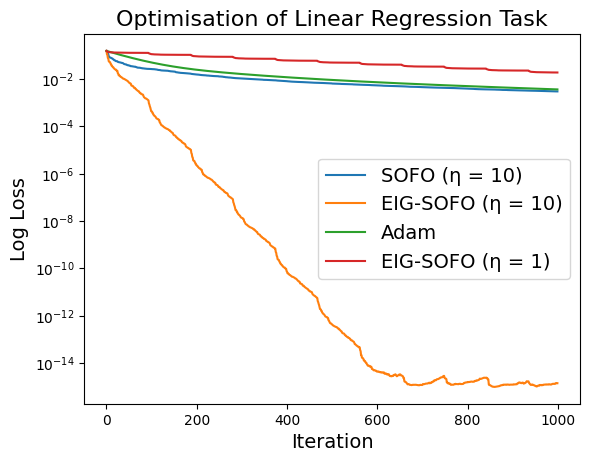

In [318]:
plt.plot(SOFO_losses, label='SOFO (η = 10)')
plt.plot(eig_SOFO_losses, label='EIG-SOFO (η = 10)')
plt.plot(adam_losses, label='Adam')
plt.plot(eig_SOFO_losses2, label='EIG-SOFO (η = 1)')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.yscale('log')
plt.legend(fontsize=14)
plt.title('Optimisation of Linear Regression Task', fontsize=16)
plt.savefig('linear_regression_optimisation.png', dpi=300)
plt.show()